# **Análisis de ventas, clientes y productos para Vanrell**

## **Introducción:**
En este proyecto vas a realizar un análisis descriptivo y estratégico para Vanrell, una reconocida marca de moda argentina especializada en carteras, indumentaria de cuero y accesorios. 

## **Descripción de la empresa: Vanrell**

Vanrell es una marca argentina de moda que se especializa en la confección y venta de carteras, accesorios y prendas de vestir. 

Con un enfoque en la calidad y el diseño, la marca trabaja con cuero 100% vacuno, utilizando tratamientos naturales y vegetales para sus productos. Su lema _"Te vestimos de pies a cabeza"_ refleja su compromiso con ofrecer una amplia gama de productos que incluyen desde carteras hasta camperas de cuero, sweaters y más. Se destaca por su estilo chic y divertido, buscando resaltar la personalidad de cada cliente a través de sus diseños únicos. 

El análisis incluirá métricas clave del negocio, un estudio de fidelidad de clientes mediante un análisis de cohortes, y una segmentación RFM que permita crear estrategias personalizadas según los hábitos de consumo.

La marca ofrece ventas tanto en su e-commerce, como en domicilios estratégicos. Cuenta con envíos a todo el país. Mantiene una presencia activa en redes sociales como Instagram y Facebook, donde presenta sus nuevas colecciones y tendencias de moda.

## **Objetivo:**
El objetivo es ayudar a la empresa a comprender su rendimiento de ventas, conocer mejor a sus clientes, y tomar decisiones basadas en datos.


### Descripcion de la base de datos:


**- Tabla: `clientes`**

| Columna         | Descripcion                                    |
| --------------- | ---------------------------------------------- |
| `cliente_id`    | Identificador único de cada cliente            |
| `provincia`     | Provincia de residencia del cliente            |
| `nombre`        | Nombre del cliente                             |



**- Tabla: `facturas`**

| Columna         | Descripcion                                      |
| --------------- | ------------------------------------------------ |
| `factura_id`    | Identificador único de la factura                |
| `fecha`         | Fecha de emisión de la factura                   |
| `cliente_id`    | Identificador del cliente que realizó la compra  |
| `provincia`     | Provincia de residencia del cliente              |
| `canal`         | Canal de venta: "Online" o "Personal"            |
| `monto_total`   | Monto total de la factura en pesos               |



**- Tabla: `productos`**

| Columna          | Descripcion                                   |
| ---------------- | --------------------------------------------- |
| `producto_id`    | Identificador único del producto              |
| `nombre`         | Nombre del producto                           |
| `categoria`      | ategoría (tipo) del producto: ejemplo, cartera, campera, etc. |
| `precio_unitario`| Precio de venta por unidad en pesos           |
| `costo`          | Precio del costo por unidad en pesos          |
| `color`          | Color del producto                            |



**- Tabla: `ventas_por_factura`**

| Columna         | Descripcion                                      |
| --------------- | ------------------------------------------------ |
| `factura_id`    | ID de la factura (relación con tabla facturas)   |
| `cliente_id`    | Identificador único de cada cliente              |
| `cantidad`      | Cantidad de unidades compradas de ese producto   |
| `monto_pesos`   | Monto total de esa línea de compra (Cantidad * precio) en pesos  |
| `producto_id`   | Identificador único del producto                 |
| `Fecha_compra`  | Fecha de la compra                               |


In [50]:
!pip install pandas matplotlib seaborn duckdb squarify numpy chardet

In [125]:
# Importar librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import squarify
import matplotlib.ticker as mtick
import numpy as np
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display, HTML

In [79]:
# Leer CSV
clientes = pd.read_csv("clientes.csv")
facturas = pd.read_csv("facturas.csv")
ventas_por_factura = pd.read_csv("ventas_por_factura.csv")
productos = pd.read_csv("productos.csv")

# **A: Exploración general del negocio (pasado y presente)**

## ¿Cual fue el monto de la totalidad de las ventas, la inversión total y la ganancia total en estos 3 años?

In [94]:
# Query de monto_inversion_ganancia df
monto_inversion_ganancia = """SELECT
	SUM(vf.monto_pesos) AS ventas_total,
    SUM(vf.cantidad * p.costo) AS costo_total,
    SUM(vf.monto_pesos - vf.cantidad * p.costo) AS ganancia
FROM ventas_por_factura vf
JOIN facturas f ON vf.factura_id = f.factura_id
JOIN productos p ON vf.producto_id = p.producto_id;"""
monto_inversion_ganancia = duckdb.query(monto_inversion_ganancia).to_df()

monto_inversion_ganancia

,ventas_total,costo_total,ganancia
0,777817300.0,394338150.0,383479150.0


Durante el período analizado **(2022–2024)**, el monto total de ventas alcanzó los **$777.817.300**. 

La inversión total en productos, calculada como el costo de los bienes vendidos, fue de **$394.338.150**. 

Esto resultó en una ganancia neta de **$383.479.150**, equivalente a un margen de ganancia aproximado del **49,3%** sobre las ventas.

## ROI - Retorno sobre el costo de todos los productos vendidos

In [96]:
roi = """SELECT
    ROUND((SUM(vf.monto_pesos - vf.cantidad * p.costo) / SUM(vf.cantidad * p.costo) )* 100,2) AS roi,
	ROUND((SUM(vf.monto_pesos - vf.cantidad * p.costo) / SUM(vf.monto_pesos)) * 100,2) AS margen
FROM ventas_por_factura vf
JOIN facturas f ON vf.factura_id = f.factura_id
JOIN productos p ON vf.producto_id = p.producto_id;"""

roi = duckdb.query(roi).to_df()
roi

,roi,margen
0,97.25,49.3


Durante el período analizado, el retorno sobre la inversión en productos fue del **97,25%**.

El margen de ganancia fue del **49,30%**, lo que indica que aproximadamente la mitad del ingreso por ventas fue utilidad neta (descontando solo el costo directo del producto).

## ¿Cuánto vendió Vanrell cada año y cuál fue el porcentaje de variacion con el año anterior?

In [97]:
ventasvariacion_anual = """WITH datos_por_año AS (
  SELECT
    LEFT(f.fecha, 4) AS año,
    SUM(vf.monto_pesos) AS monto_total,
    SUM(vf.cantidad * p.costo) AS costo_total,
    SUM(vf.monto_pesos - vf.cantidad * p.costo) AS ganancia
  FROM ventas_por_factura vf
  JOIN facturas f ON vf.factura_id = f.factura_id
  JOIN productos p ON vf.producto_id = p.producto_id
  GROUP BY LEFT(f.fecha, 4)
)

SELECT 
	año,
	monto_total,
	CONCAT(
    	ROUND(
    		CASE 
        		WHEN LAG(monto_total) OVER (ORDER BY año) IS NULL THEN NULL
        		ELSE 100.0 * (monto_total - LAG(monto_total) OVER (ORDER BY año)) / LAG(monto_total) OVER (ORDER BY año)
      		END, 2), '%') AS porcentaje_cambio,
	ganancia
FROM datos_por_año
ORDER BY año;"""

ventasvariacion_anual = duckdb.query(ventasvariacion_anual).to_df()

ventasvariacion_anual

,año,monto_total,porcentaje_cambio,ganancia
0,2022,250292200.0,%,123392530.0
1,2023,268576300.0,7.31%,132375360.0
2,2024,258948800.0,-3.58%,127711260.0


Se analizaron la evolución de ventas con el tiempo: 

➖ **2022** se dio inicio de la toma de datos y sera nuestro punto de partida. 

🔺 **2023** fue el mejor año en términos de ventas, con un crecimiento de aproximadamente 7,3% respecto a 2022, marcando el punto más alto del período analizado.

🔻 En **2024** las ventas cayeron levemente, con una disminución de alrededor de 3,6% respecto al año anterior, aunque se mantuvieron por encima del nivel de **2022**.

Este comportamiento sugiere un pico de rendimiento en **2023**, seguido de una estabilización en **2024**. Podría atribuirse a cambios en la demanda, campañas comerciales específicas o contexto económico.

## ¿Cómo evolucionaron las ventas mensuales por canal (Online vs Presencial)?

In [100]:
ventas_mensuales_por_canal = """WITH ventas_mensuales AS (
  SELECT
    SUBSTR(fecha, 1, 4) AS año,
    SUBSTR(fecha, 6, 2) AS mes_num,
    CASE SUBSTR(fecha, 6, 2)
      WHEN '01' THEN 'Enero'
      WHEN '02' THEN 'Febrero'
      WHEN '03' THEN 'Marzo'
      WHEN '04' THEN 'Abril'
      WHEN '05' THEN 'Mayo'
      WHEN '06' THEN 'Junio'
      WHEN '07' THEN 'Julio'
      WHEN '08' THEN 'Agosto'
      WHEN '09' THEN 'Septiembre'
      WHEN '10' THEN 'Octubre'
      WHEN '11' THEN 'Noviembre'
      WHEN '12' THEN 'Diciembre'
    END AS mes,
    canal,
    SUM(monto_total) AS monto_total
  FROM facturas
  GROUP BY año, SUBSTR(fecha, 6, 2), canal
),
pivot_table AS (
  SELECT
    año,
    mes_num,
    mes,
    MAX(CASE WHEN canal = 'Online' THEN monto_total END) AS total_online,
    MAX(CASE WHEN canal = 'Personal' THEN monto_total END) AS total_personal
  FROM ventas_mensuales
  GROUP BY año, mes_num, mes
)

SELECT
  año,
  mes,
  total_online,
  total_personal,
  CONCAT(ROUND(100 - (total_personal * 100.0 / total_online), 2), ' %') AS diferencia_pct_entre_canales
FROM pivot_table
ORDER BY año, mes_num;"""

ventas_mensuales_por_canal = duckdb.query(ventas_mensuales_por_canal).to_df()
ventas_mensuales_por_canal

,año,mes,total_online,total_personal,diferencia_pct_entre_canales
0,2022,Enero,19642800.0,2501200.0,87.27 %
1,2022,Febrero,16731700.0,1732700.0,89.64 %
2,2022,Marzo,17474300.0,905700.0,94.82 %
3,2022,Abril,19170500.0,1651900.0,91.38 %
4,2022,Mayo,21135200.0,1475100.0,93.02 %
5,2022,Junio,18032600.0,2203700.0,87.78 %
6,2022,Julio,18600300.0,2282600.0,87.73 %
7,2022,Agosto,17894700.0,2329100.0,86.98 %
8,2022,Septiembre,19049600.0,3037500.0,84.05 %
9,2022,Octubre,21003500.0,2135500.0,89.83 %


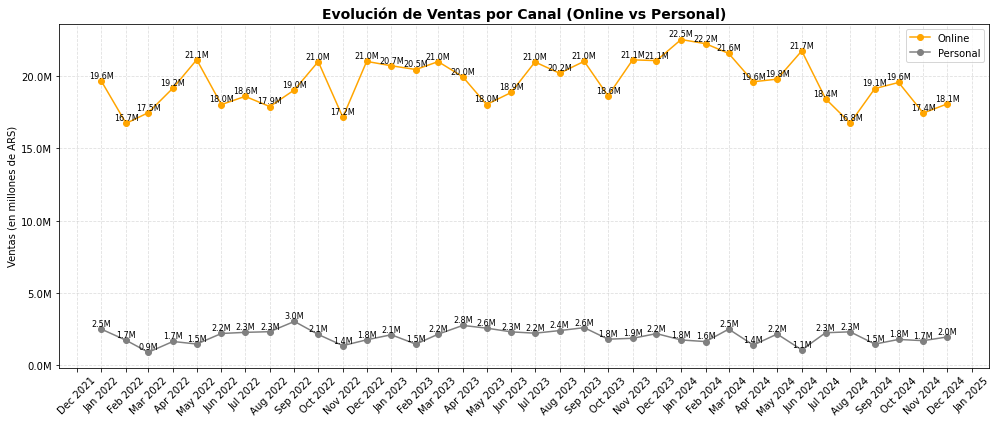

In [101]:
df = ventas_mensuales_por_canal

# Ordenar fechas
meses_orden = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
               'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
df['mes_num'] = df['mes'].apply(lambda x: meses_orden.index(x) + 1)
df['fecha'] = pd.to_datetime({'year': df['año'], 'month': df['mes_num'], 'day': 1})
df = df.sort_values('fecha')

# Función para formatear millones
def millones(x):
    return f"{x/1e6:.1f}M"

# Crear gráfico
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df['fecha'], df['total_online'], marker='o', color='orange', label='Online')
ax.plot(df['fecha'], df['total_personal'], marker='o', color='grey', label='Personal')

# Etiquetas sobre los puntos
for x, y in zip(df['fecha'], df['total_online']):
    ax.text(x, y + 2e5, millones(y), ha='center', fontsize=8, color='black')
for x, y in zip(df['fecha'], df['total_personal']):
    ax.text(x, y + 2e5, millones(y), ha='center', fontsize=8, color='black')

# Formato eje Y en millones
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: millones(x)))
ax.set_ylabel('Ventas (en millones de ARS)')
ax.set_title('Evolución de Ventas por Canal (Online vs Personal)', fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend()

# Más ticks en eje X: uno por mes
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Ticks mensuales
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Formato "Ene 2022", "Feb 2022", etc.

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Canal Online:**
Representa la mayoría de las ventas mensuales en todos los meses del período 2022–2024.

Mantuvo un volumen estable y elevado, con picos en meses como:

 - **Enero 2024**: _$22.530.000_
 
 - **Febrero 2024**: _$22.242.000_
 
 - **Diciembre 2023**: _$21.072.000_

Mostró un comportamiento muy regular, lo que indica una estrategia consolidada en e-commerce y un público fiel.
 
 
**Canal Presencial:**
Si bien tuvo una participación menor, sigue siendo relevante como canal complementario.

Las ventas presenciales fluctúan más y suelen estar por debajo de los $3 millones por mes.

Sus mejores meses fueron:

 - **Marzo 2024**: _$2.504.800_

 - **Julio 2024**: _$2.257.100_

 - **Agosto 2023**: _$2.405.200_

**Comparativa general:**

La tendencia sugiere que la estrategia digital es el motor principal del crecimiento en ingresos.

No hay signos de reemplazo total del canal presencial, pero su impacto es significativamente menor.

## ¿Qué canal de ventas (online/presencial) genera más ingresos?

In [103]:
ventastotal_por_canal = """SELECT
  canal,
  COUNT(*) AS num_por_canal,
  SUM(monto_total) AS monto_total_por_canal,
  ROUND(AVG(monto_total), 2) AS promedio_por_factura,
  CONCAT(ROUND(100.0 * SUM(monto_total) / (SELECT SUM(monto_total) FROM facturas), 2), ' %') AS porcen_ventas
FROM facturas
GROUP BY canal;"""

ventastotal_por_canal = duckdb.query(ventastotal_por_canal).to_df()

ventastotal_por_canal

,canal,num_por_canal,monto_total_por_canal,promedio_por_factura,porcen_ventas
0,Online,8273,705871800.0,85322.35,90.75 %
1,Personal,842,71945500.0,85445.96,9.25 %


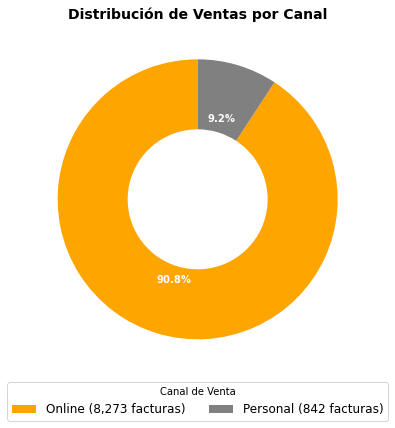

In [104]:
df = ventastotal_por_canal

# Aseguramos el orden de canales si es necesario
df = df.set_index('canal').loc[['Online', 'Personal']].reset_index()

labels = df['canal']
sizes = df['monto_total_por_canal']
cantidades = df['num_por_canal']
colors = ['orange', 'grey']

# Crear gráfico de torta tipo donut
fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    wedgeprops=dict(width=0.5),
    textprops={'color': 'white', 'weight': 'bold'}
)

# Agregar círculo blanco al centro
centre_circle = plt.Circle((0, 0), 0.35, fc='white')
fig.gca().add_artist(centre_circle)

# Título
ax.set_title('Distribución de Ventas por Canal', fontsize=14, fontweight='bold')

# Leyenda personalizada con cantidad de facturas
plt.legend(wedges,
           [f"{l} ({c:,} facturas)" for l, c in zip(labels, cantidades)],
           title="Canal de Venta",
           loc="lower center",
           bbox_to_anchor=(0.5, -0.15),
           ncol=2,
           fontsize=12)

plt.tight_layout()
plt.show()

- El canal Online fue el que generó más ingresos, con un total de _$705.871.800_, lo que representa un **90,75%** del total de ventas.

- En contraste, el canal Presencial facturó _$71.945.500_, equivalente al **9,25%** del total.


A pesar de que ambos canales tienen una factura promedio muy similar (alrededor de _$85.300_), la diferencia en volumen de facturas emitidas es significativa:

Online: **8.273** facturas

Presencial: **842** facturas

Esto confirma que la mayor parte de la actividad comercial se concentra en el canal online, tanto en cantidad de operaciones como en ingresos generados.

## **Top 5 meses con más ventas**

In [107]:
top_5_meses_mayores_ventas = """SELECT
	CASE SUBSTR(fecha, 6, 2)
    	WHEN '01' THEN 'Enero'
    	WHEN '02' THEN 'Febrero'
    	WHEN '03' THEN 'Marzo'
    	WHEN '04' THEN 'Abril'
    	WHEN '05' THEN 'Mayo'
    	WHEN '06' THEN 'Junio'
    	WHEN '07' THEN 'Julio'
    	WHEN '08' THEN 'Agosto'
    	WHEN '09' THEN 'Septiembre'
    	WHEN '10' THEN 'Octubre'
    	WHEN '11' THEN 'Noviembre'
    	WHEN '12' THEN 'Diciembre'
	END AS mes,
	STRFTIME(CAST(fecha AS DATE), '%Y') AS año,
	SUM(monto_total) AS total
FROM facturas
GROUP BY 1,2
ORDER BY total DESC
LIMIT 5;"""

top_5_meses_mayores_ventas = duckdb.query(top_5_meses_mayores_ventas).to_df()

top_5_meses_mayores_ventas

,mes,año,total
0,Enero,2024,24287400.0
1,Marzo,2024,24069800.0
2,Febrero,2024,23886400.0
3,Septiembre,2023,23632000.0
4,Diciembre,2023,23268200.0


1. Primer trimestre de **2024** (**enero**, **febrero** y **marzo**) concentró los niveles más altos de ventas del período, lo que indica un fuerte inicio de año, posiblemente impulsado por promociones de temporada, renovación de inventario o campañas post-festivas.

2. **Diciembre 2023** aparece como un mes destacado, lo cual es consistente con los patrones de compra de fin de año, donde el consumo tiende a aumentar por motivos festivos.

3. **Septiembre 2023** también se posiciona entre los meses con mayores ingresos, lo que podría señalar una reactivación luego del receso invernal o el inicio de nuevas campañas de marketing.

- Estos datos permiten identificar momentos clave del año donde las ventas alcanzaron sus picos, información útil para planificar futuras estrategias comerciales, ajustar campañas publicitarias y reforzar el stock en los períodos de mayor demanda.

## **¿Cuál fue el mes que más facturas se emitieron?**

In [109]:
mes_mas_facturas = """WITH total_ventas_por_mes AS 
	(SELECT
		  STRFTIME('%B %Y', CAST(fecha AS DATE)) AS mes_año,
		  COUNT(*) AS total
	FROM facturas
	GROUP BY STRFTIME('%B %Y', CAST(fecha AS DATE))
	ORDER BY total DESC)

SELECT *
FROM total_ventas_por_mes
WHERE total = (SELECT MAX(total) FROM total_ventas_por_mes);"""

mes_mas_facturas = duckdb.query(mes_mas_facturas).to_df()

mes_mas_facturas

,mes_año,total
0,March 2024,283


Para medir volumen de ventas: **Marzo de 2024** fue el mes con mayor cantidad de facturas pero no fue el mes con un monto mayor de venta

## **¿Cuántas facturas se emiten por mes?**

In [113]:
facturas_por_mes = """SELECT
  SUBSTR(fecha, 1, 4) AS año,
  CASE SUBSTR(fecha, 6, 2)
    WHEN '01' THEN 'Enero'
    WHEN '02' THEN 'Febrero'
    WHEN '03' THEN 'Marzo'
    WHEN '04' THEN 'Abril'
    WHEN '05' THEN 'Mayo'
    WHEN '06' THEN 'Junio'
    WHEN '07' THEN 'Julio'
    WHEN '08' THEN 'Agosto'
    WHEN '09' THEN 'Septiembre'
    WHEN '10' THEN 'Octubre'
    WHEN '11' THEN 'Noviembre'
    WHEN '12' THEN 'Diciembre'
  END AS mes,
  ROUND(AVG(monto_total),2) AS promedio_factura_por_mes,
  COUNT(*) AS facturas_por_mes
FROM facturas
GROUP BY año, SUBSTR(fecha, 6, 2)
ORDER BY promedio_factura_por_mes DESC;"""

evolucion_facturas_por_mes = duckdb.query(facturas_por_mes).to_df()

evolucion_facturas_por_mes

,año,mes,promedio_factura_por_mes,facturas_por_mes
0,2023,Diciembre,91607.09,254
1,2023,Abril,90510.76,251
2,2022,Junio,90340.63,224
3,2024,Noviembre,89928.17,213
4,2022,Agosto,88700.88,228
5,2024,Abril,88670.04,237
6,2024,Febrero,87817.65,272
7,2024,Octubre,87515.98,244
8,2024,Enero,87051.61,279
9,2023,Febrero,87001.19,252


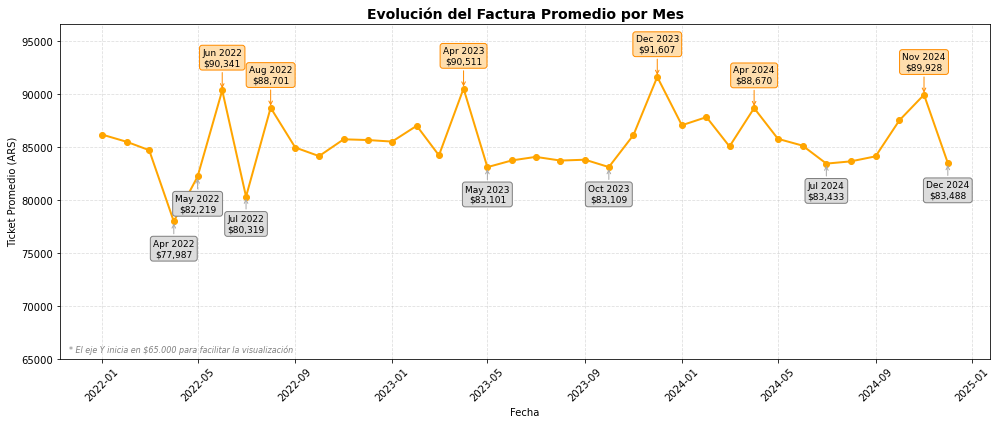

In [118]:
# Ordenar fechas
meses_orden = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
               'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
df['mes_num'] = df['mes'].apply(lambda x: meses_orden.index(x) + 1)
df['fecha'] = pd.to_datetime({'year': df['año'], 'month': df['mes_num'], 'day': 1})
df = df.sort_values('fecha')

# Crear gráfico
plt.figure(figsize=(14, 6))
plt.plot(df['fecha'], df['promedio_factura_por_mes'], marker='o', color='orange', linewidth=2)

# Etiquetar los 6 máximos
top_6 = df.nlargest(6, 'promedio_factura_por_mes')
for _, row in top_6.iterrows():
    plt.annotate(f"{row['fecha'].strftime('%b %Y')}\n${row['promedio_factura_por_mes']:,.0f}",
                 xy=(row['fecha'], row['promedio_factura_por_mes']),
                 xytext=(0, 25),
                 textcoords='offset points',
                 ha='center',
                 fontsize=9,
                 bbox=dict(boxstyle="round,pad=0.3", fc="navajowhite", ec="darkorange", lw=1),
                 arrowprops=dict(arrowstyle='->', color='darkorange'))

# Etiquetar los 7 mínimos
bottom_7 = df.nsmallest(7, 'promedio_factura_por_mes')
for _, row in bottom_7.iterrows():
    plt.annotate(f"{row['fecha'].strftime('%b %Y')}\n${row['promedio_factura_por_mes']:,.0f}",
                 xy=(row['fecha'], row['promedio_factura_por_mes']),
                 xytext=(0, -35),
                 textcoords='offset points',
                 ha='center',
                 fontsize=9,
                 bbox=dict(boxstyle="round,pad=0.3", fc="gainsboro", ec="grey", lw=1),
                 arrowprops=dict(arrowstyle='->', color='darkgrey'))

# Nota aclaratoria
plt.text(
    0.01, 0.02,
    "* El eje Y inicia en $65.000 para facilitar la visualización",
    transform=plt.gca().transAxes,
    fontsize=8,
    style='italic',
    color='gray'
)

# Estética
plt.title('Evolución del Factura Promedio por Mes', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Ticket Promedio (ARS)')
plt.ylim(65000, df['promedio_factura_por_mes'].max() + 5000)
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

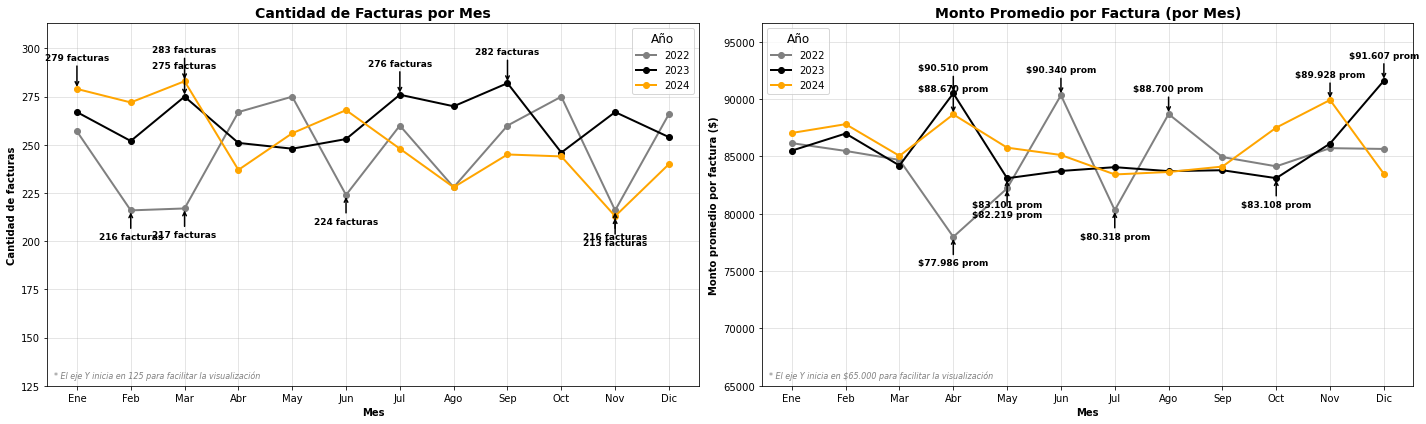

,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
año1,,,,,,,,,,,,
2022,257,216,217,267,275,224,260,228,260,275,216,266
2023,267,252,275,251,248,253,276,270,282,246,267,254
2024,279,272,283,237,256,268,248,228,245,244,213,240
,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
año2,,,,,,,,,,,,
2022,86163.42,85483.33,84700.46,77986.52,82219.27,90340.63,80318.85,88700.88,84950.38,84141.82,85726.39,85658.27
2023,85510.86,87001.19,84212.73,90510.76,83101.21,83736.76,84068.84,83721.85,83801.42,83108.94,86129.21,91607.09
2024,87051.61,87817.65,85052.30,88670.04,85769.92,85130.97,83433.47,83647.81,84119.59,87515.98,89928.17,83487.92


In [126]:
# ------------------- 1. Cargar Datos desde DuckDB -------------------

facturas_emitidas_por_mes = duckdb.query("""
    SELECT
        SUBSTR(fecha, 1, 4) AS año1,
        ROUND(COUNT(CASE WHEN SUBSTR(fecha, 6, 2) = '01' THEN monto_total END), 2) AS Ene,
        ROUND(COUNT(CASE WHEN SUBSTR(fecha, 6, 2) = '02' THEN monto_total END), 2) AS Feb,
        ROUND(COUNT(CASE WHEN SUBSTR(fecha, 6, 2) = '03' THEN monto_total END), 2) AS Mar,
        ROUND(COUNT(CASE WHEN SUBSTR(fecha, 6, 2) = '04' THEN monto_total END), 2) AS Abr,
        ROUND(COUNT(CASE WHEN SUBSTR(fecha, 6, 2) = '05' THEN monto_total END), 2) AS May,
        ROUND(COUNT(CASE WHEN SUBSTR(fecha, 6, 2) = '06' THEN monto_total END), 2) AS Jun,
        ROUND(COUNT(CASE WHEN SUBSTR(fecha, 6, 2) = '07' THEN monto_total END), 2) AS Jul,
        ROUND(COUNT(CASE WHEN SUBSTR(fecha, 6, 2) = '08' THEN monto_total END), 2) AS Ago,
        ROUND(COUNT(CASE WHEN SUBSTR(fecha, 6, 2) = '09' THEN monto_total END), 2) AS Sep,
        ROUND(COUNT(CASE WHEN SUBSTR(fecha, 6, 2) = '10' THEN monto_total END), 2) AS Oct,
        ROUND(COUNT(CASE WHEN SUBSTR(fecha, 6, 2) = '11' THEN monto_total END), 2) AS Nov,
        ROUND(COUNT(CASE WHEN SUBSTR(fecha, 6, 2) = '12' THEN monto_total END), 2) AS Dic
    FROM facturas
    GROUP BY año1
    ORDER BY año1
""").to_df()

facturacion_por_mes = duckdb.query("""
    SELECT
        SUBSTR(fecha, 1, 4) AS año2,
        ROUND(AVG(CASE WHEN SUBSTR(fecha, 6, 2) = '01' THEN monto_total END), 2) AS Ene,
        ROUND(AVG(CASE WHEN SUBSTR(fecha, 6, 2) = '02' THEN monto_total END), 2) AS Feb,
        ROUND(AVG(CASE WHEN SUBSTR(fecha, 6, 2) = '03' THEN monto_total END), 2) AS Mar,
        ROUND(AVG(CASE WHEN SUBSTR(fecha, 6, 2) = '04' THEN monto_total END), 2) AS Abr,
        ROUND(AVG(CASE WHEN SUBSTR(fecha, 6, 2) = '05' THEN monto_total END), 2) AS May,
        ROUND(AVG(CASE WHEN SUBSTR(fecha, 6, 2) = '06' THEN monto_total END), 2) AS Jun,
        ROUND(AVG(CASE WHEN SUBSTR(fecha, 6, 2) = '07' THEN monto_total END), 2) AS Jul,
        ROUND(AVG(CASE WHEN SUBSTR(fecha, 6, 2) = '08' THEN monto_total END), 2) AS Ago,
        ROUND(AVG(CASE WHEN SUBSTR(fecha, 6, 2) = '09' THEN monto_total END), 2) AS Sep,
        ROUND(AVG(CASE WHEN SUBSTR(fecha, 6, 2) = '10' THEN monto_total END), 2) AS Oct,
        ROUND(AVG(CASE WHEN SUBSTR(fecha, 6, 2) = '11' THEN monto_total END), 2) AS Nov,
        ROUND(AVG(CASE WHEN SUBSTR(fecha, 6, 2) = '12' THEN monto_total END), 2) AS Dic
    FROM facturas
    GROUP BY año2
    ORDER BY año2
""").to_df()

# ------------------- 2. Limpieza y Organización -------------------

orden_meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
               'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
colores = ['gray', 'black', 'orange']

facturas_emitidas_por_mes = facturas_emitidas_por_mes.set_index('año1')[orden_meses]
facturacion_por_mes = facturacion_por_mes.set_index('año2')[orden_meses]

# ------------------- 3. Gráficos en paralelo -------------------

fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

# --- G1: Cantidad de Facturas ---
ax1 = axs[0]
for i, año in enumerate(facturas_emitidas_por_mes.index):
    ax1.plot(
        orden_meses,
        facturas_emitidas_por_mes.loc[año],
        label=str(año),
        color=colores[i % len(colores)],
        linewidth=2,
        marker='o'
    )

df1_long = facturas_emitidas_por_mes.reset_index().rename(columns={'año1': 'año'}).melt(id_vars='año', var_name='mes', value_name='facturas')
top_5 = df1_long.nlargest(5, 'facturas')
bottom_5 = df1_long.nsmallest(5, 'facturas')
extremos1 = pd.concat([top_5, bottom_5])

for _, row in extremos1.iterrows():
    desplazamiento = 15 if row['facturas'] in top_5['facturas'].values else -15
    ax1.annotate(
        f"{int(row['facturas'])} facturas",
        xy=(row['mes'], row['facturas']),
        xytext=(row['mes'], row['facturas'] + desplazamiento),
        textcoords='data',
        ha='center',
        fontsize=9,
        fontweight='bold',
        arrowprops=dict(facecolor='red', arrowstyle='->', lw=1.5)
    )

ax1.set_title('Cantidad de Facturas por Mes', fontweight='bold', fontsize=14)
ax1.set_xlabel('Mes', fontweight='bold')
ax1.set_ylabel('Cantidad de facturas', fontweight='bold')
ax1.set_ylim(125, facturas_emitidas_por_mes.values.max() + 30)
ax1.grid(True, alpha=0.4)
ax1.legend(title="Año", title_fontsize=12, fontsize=10)
ax1.text(0.01, 0.02, "* El eje Y inicia en 125 para facilitar la visualización",
         transform=ax1.transAxes, fontsize=8, style='italic', color='gray')

# --- G2: Monto Promedio ---
ax2 = axs[1]
for i, año in enumerate(facturacion_por_mes.index):
    ax2.plot(
        orden_meses,
        facturacion_por_mes.loc[año],
        label=str(año),
        color=colores[i % len(colores)],
        linewidth=2,
        marker='o'
    )

df2_long = facturacion_por_mes.reset_index().rename(columns={'año2': 'año'}).melt(id_vars='año', var_name='mes', value_name='promedio')
top = df2_long.nlargest(6, 'promedio')
bottom = df2_long.nsmallest(5, 'promedio')
top = top[~((top['mes'] == 'May') & (top['promedio'] > top[top['mes'] == 'May']['promedio'].min()))]
dic_2024 = df2_long[(df2_long['año'] == 2024) & (df2_long['mes'] == 'Dic')]
extremos2 = pd.concat([top, bottom, dic_2024]).drop_duplicates()

for _, row in extremos2.iterrows():
    desplazamiento = 2000 if row['promedio'] in top['promedio'].values else -2500
    if (row['mes'] == 'Dic') and (row['año'] == 2024):
        desplazamiento = -2500
    ax2.annotate(
        f"${int(row['promedio']):,}".replace(",", ".") + " prom",
        xy=(row['mes'], row['promedio']),
        xytext=(row['mes'], row['promedio'] + desplazamiento),
        textcoords='data',
        ha='center',
        fontsize=9,
        fontweight='bold',
        arrowprops=dict(facecolor='red', arrowstyle='->', lw=1.5)
    )

ax2.set_title('Monto Promedio por Factura (por Mes)', fontweight='bold', fontsize=14)
ax2.set_xlabel('Mes', fontweight='bold')
ax2.set_ylabel('Monto promedio por factura ($)', fontweight='bold')
ax2.set_ylim(65000, facturacion_por_mes.values.max() + 5000)
ax2.grid(True, alpha=0.4)
ax2.legend(title="Año", title_fontsize=12, fontsize=10)
ax2.text(0.01, 0.02, "* El eje Y inicia en $65.000 para facilitar la visualización",
         transform=ax2.transAxes, fontsize=8, style='italic', color='gray')

# Final
plt.tight_layout()
plt.show()

# Mostrar los dos DataFrames al lado
display(HTML(f"""
<div style="display: flex; justify-content: space-between;">
  <div style="margin-right: 20px;">{facturas_emitidas_por_mes.head().to_html()}</div>
  <div>{facturacion_por_mes.head().to_html()}</div>
</div>
"""))


El mes con mayor cantidad de facturas:

 - **Marzo 2024**: **283** facturas emitidas

 - **Septiembre 2023**: **282** facturas

 - **Junio 2024**: **268** facturas

Meses con menor cantidad de facturas:

 - **Noviembre 2024**: **213** facturas

 - **Junio 2022**: **224** facturas

 - **Agosto 2024**: **228** facturas

Promedio por factura:

El valor promedio por factura se mantuvo dentro de un rango relativamente estable.

**Diciembre 2023** fue el mes con la factura promedio más alta: _$ 91.607,09_.

**Abril 2022** tuvo el promedio más bajo: _$ 77.986,52_.


La empresa mantiene un flujo constante de ventas mensuales, con picos durante ciertos períodos que podrían coincidir con campañas de temporada o eventos comerciales.

Este tipo de análisis permite detectar meses de alta rotación para reforzar stock, personal y campañas, así como identificar meses más débiles donde se pueden aplicar estrategias promocionales para aumentar el volumen de operaciones.

# B - Exploración clientes, provincias y productos:

## **¿Cuál es el valor promedio de compra por cliente?**

In [128]:
promedio_compra_cliente = """SELECT 
	ROUND(AVG(monto_total),2) AS promedio_factura
FROM facturas;"""

promedio_compra_cliente = duckdb.query(promedio_compra_cliente).to_df()
promedio_compra_cliente

,promedio_factura
0,85333.77


El valor promedio de compra, considerando todas las compras y todos los clientes, es de _$85.333,77._

Nos sirve como referencia para evaluar el comportamiento de compra, detectar desviaciones (facturas muy altas o bajas) y establecer metas para las facturas promedio.

También puede utilizarse como indicador clave en campañas de marketing o estrategias de fidelización: por ejemplo, incentivar compras mayores al promedio mediante beneficios o descuentos.

## **Top 10 clientes historicos que más ganancia generaron en pesos**

In [130]:
top_10_clientes_por_ganancia = """WITH facturas_cliente AS (
    SELECT 
        cliente_id, 
        SUM(monto_total) AS monto_total
    FROM facturas
    GROUP BY cliente_id
),
costos_cliente AS (
    SELECT 
        f.cliente_id,
        SUM(vpf.cantidad * p.costo) AS costo_total
    FROM ventas_por_factura vpf
    JOIN facturas f ON f.factura_id = vpf.factura_id
    JOIN productos p ON p.producto_id = vpf.producto_id
    GROUP BY f.cliente_id
)

SELECT 
    c.nombre AS nombre_cliente,
    fc.monto_total,
    fc.monto_total - cc.costo_total AS ganancia,
    CONCAT(ROUND((fc.monto_total - cc.costo_total) * 100.0 / fc.monto_total, 2), ' %') AS profit_porcentual
FROM facturas_cliente fc
JOIN costos_cliente cc ON fc.cliente_id = cc.cliente_id
JOIN clientes c ON c.cliente_id = fc.cliente_id
ORDER BY fc.monto_total DESC
LIMIT 10;""" 

top_10_clientes_por_ganancia = duckdb.query(top_10_clientes_por_ganancia).to_df()
top_10_clientes_por_ganancia

,nombre_cliente,monto_total,ganancia,profit_porcentual
0,Horacio Fabbri,1092600.0,543890.0,49.78 %
1,Gisela Zarate,851800.0,429150.0,50.38 %
2,Isidora Kozak,844100.0,411610.0,48.76 %
3,Pilar Amato,827900.0,403410.0,48.73 %
4,Celeste Rivas,825200.0,396200.0,48.01 %
5,Luciana Ortega,814800.0,411500.0,50.5 %
6,Carla Ricci,808400.0,402370.0,49.77 %
7,Horacio Jiménez,802100.0,398650.0,49.7 %
8,Ximena Juárez,789700.0,392320.0,49.68 %
9,Yamila Torres,785400.0,380570.0,48.46 %


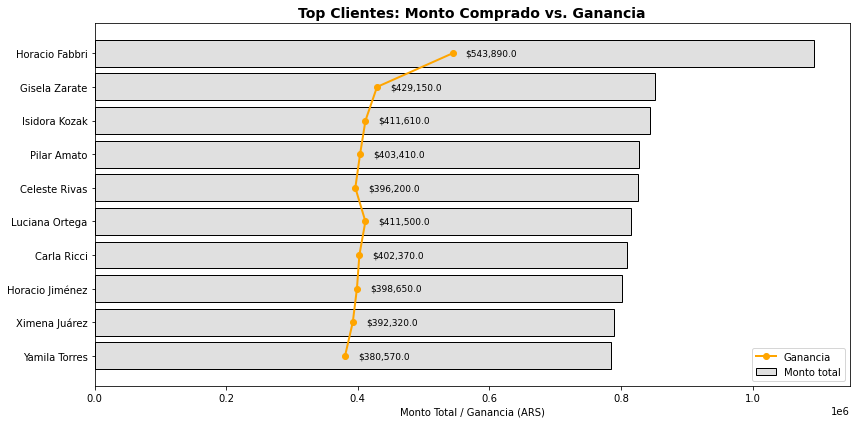

In [131]:
# Función para graficar
def graficar_top_clientes(df):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Barras horizontales en escala de grises
    gray_colors = ['#e0e0e0'] * len(df)
    ax.barh(df['nombre_cliente'], df['monto_total'], color=gray_colors, edgecolor='black', label='Monto total')

    # Línea de ganancia en naranja
    ax.plot(df['ganancia'], df['nombre_cliente'], color='orange', marker='o', linewidth=2, label='Ganancia')

    # Etiquetas de ganancia
    for g, n in zip(df['ganancia'], df['nombre_cliente']):
        ax.text(g + 20000, n, f"${g:,}", va='center', fontsize=9, color='black')

    # Ejes y leyenda
    ax.set_xlabel('Monto Total / Ganancia (ARS)')
    ax.set_title('Top Clientes: Monto Comprado vs. Ganancia', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Llamada a la función con tu DataFrame
graficar_top_clientes(top_10_clientes_por_ganancia)



Estos clientes representan una porción destacada del ingreso total, lo que los posiciona como clientes estratégicos para la empresa.

Son candidatos ideales para programas de fidelización personalizados, promociones exclusivas o acciones de retención de alto valor.

Analizar su comportamiento de compra (frecuencia, productos favoritos, canales) puede ofrecer insights para replicar ese patrón en otros segmentos.

También podemos detectar que la ganacia es aproximadamente del 50% de las compras. 

## **¿Cuáles fueron los 10 productos más vendidos por canal/provincia?**

In [135]:
top_10_productos_por_canal = """WITH top_productos AS (
	SELECT 
		v.producto_id AS producto_id,
		SUM(v.cantidad) AS total_vendido
	FROM ventas_por_factura v
	GROUP BY v.producto_id
	ORDER BY total_vendido DESC
	LIMIT 10
)

SELECT
	p.nombre AS producto,
	p.categoria,
	f.canal,
	f.provincia,
	SUM(v.cantidad) AS cantidad_vendida,
FROM ventas_por_factura v
JOIN facturas f ON v.factura_id = f.factura_id
JOIN productos p ON v.producto_id = p.producto_id
JOIN top_productos tp ON v.producto_id = tp.producto_id
GROUP BY p.nombre, p.categoria, f.canal, f.provincia
ORDER BY cantidad_vendida DESC
LIMIT 10;"""
top_10_productos_por_canal = duckdb.query(top_10_productos_por_canal).to_df()
top_10_productos_por_canal

,producto,categoria,canal,provincia,cantidad_vendida
0,Bandolera grande gris,Carteras,Online,Santa Fe,187.0
1,Cinturón con hebilla verde,Accesorios,Online,Santa Fe,172.0
2,Mochila simple naranja,Carteras,Online,Santa Fe,171.0
3,Cinturón liso azul,Accesorios,Online,Santa Fe,167.0
4,Campera con corderito violeta,Ropa,Online,Santa Fe,166.0
5,Billetera clásica marrón,Accesorios,Online,Santa Fe,165.0
6,Campera inflable beige,Ropa,Online,Santa Fe,159.0
7,Cartera de cuero beige,Carteras,Online,Santa Fe,155.0
8,Campera biker blanco,Ropa,Online,Santa Fe,154.0
9,Bandolera chica violeta,Carteras,Online,Santa Fe,137.0


Todos los productos fueron adquiridos a través del canal online.

**Santa Fe** concentra la mayor cantidad de compras de estos artículos, lo que podría indicar:

Una alta penetración del canal digital en la provincia.

Una fuerte preferencia regional por ciertos productos (billeteras, mochilas, camperas).

Los productos más vendidos pertenecen mayormente a categorías de accesorios y abrigo, lo cual puede estar influenciado por temporada, precio o promociones.

## **¿Cual es el producto que más se vendió?**

In [140]:
producto_mas_vendido = """SELECT
	p.nombre,
	p.categoria,
	SUM(vf.cantidad) AS cantidad_comprada
FROM productos p
JOIN ventas_por_factura vf ON p.producto_id = vf.producto_id
GROUP BY p.nombre, p.categoria
ORDER BY cantidad_comprada DESC
LIMIT 10;"""
producto_mas_vendido = duckdb.query(producto_mas_vendido).to_df()
producto_mas_vendido

,nombre,categoria,cantidad_comprada
0,Cinturón con hebilla verde,Accesorios,364.0
1,Bandolera grande gris,Carteras,348.0
2,Billetera clásica marrón,Accesorios,341.0
3,Mochila simple naranja,Carteras,339.0
4,Campera con corderito violeta,Ropa,334.0
5,Cinturón liso azul,Accesorios,328.0
6,Campera biker blanco,Ropa,325.0
7,Campera inflable beige,Ropa,325.0
8,Bandolera chica violeta,Carteras,324.0
9,Cartera de cuero beige,Carteras,323.0


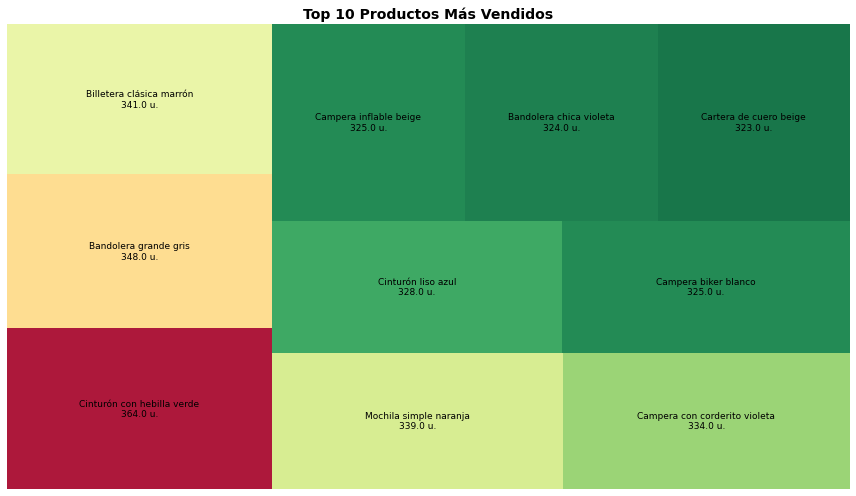

In [141]:
# Defino df
df = producto_mas_vendido

# Etiquetas y tamaño
labels = [f"{row['nombre']}\n{row['cantidad_comprada']} u." for _, row in df.iterrows()]
sizes = df['cantidad_comprada']

# Heatmap: más alto = rojo, más bajo = verde
norm = plt.Normalize(min(sizes), max(sizes))
colors = plt.cm.RdYlGn_r(norm(sizes))  # RdYlGn reversed para que rojo sea más alto

# Treemap
plt.figure(figsize=(12, 7))
squarify.plot(
    sizes=sizes,
    label=labels,
    color=colors,
    alpha=0.9,
    text_kwargs={'fontsize': 9}
)
plt.axis('off')
plt.title("Top 10 Productos Más Vendidos", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## ¿Qué categorías prefiere más la gente?

In [143]:
categoria_preferida = """SELECT 
	p.categoria,
	SUM(vpf.cantidad) AS cantidad,
	SUM(monto_pesos) AS monto
FROM ventas_por_factura vpf
JOIN productos p
ON vpf.producto_id = p.producto_id
GROUP BY p.categoria
ORDER BY monto DESC;"""
categoria_preferida = duckdb.query(categoria_preferida).to_df()
categoria_preferida

,categoria,cantidad,monto
0,Ropa,21712.0,461876900.0
1,Carteras,11079.0,187218700.0
2,Accesorios,14849.0,128721700.0


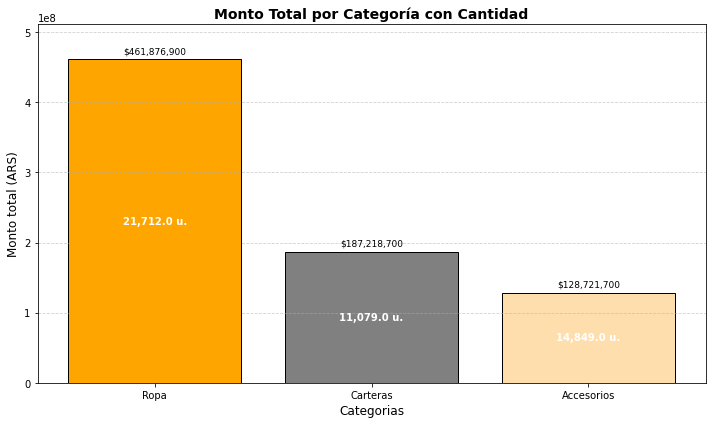

In [154]:
# Datos
df = categoria_preferida

# Colores por categoría
colors = ['orange', 'grey', 'navajowhite']

# Crear gráfico
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df['categoria'], df['monto'], color=colors, edgecolor='black')

# Etiquetas: cantidad (dentro), monto (arriba), ticket promedio (abajo)
for i, bar in enumerate(bars):
    height = bar.get_height()
    cantidad = df['cantidad'][i]
    monto = df['monto'][i]

    # Cantidad dentro
    ax.text(bar.get_x() + bar.get_width()/2, height / 2, f"{cantidad:,} u.",
            ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    
    # Monto total arriba
    ax.text(bar.get_x() + bar.get_width()/2, height + 5e6, f"${monto:,.0f}",
            ha='center', va='bottom', color='black', fontsize=9)

# Ajustes estéticos
ax.set_title('Monto Total por Categoría con Cantidad', fontsize=14, fontweight='bold')
ax.set_ylabel('Monto total (ARS)', fontsize=12)
ax.set_xlabel('Categorias', fontsize=12)
ax.set_ylim(0, max(df['monto']) + 5e7)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


La ropa es claramente la categoría más popular, tanto en unidades como en ingresos. Esto se debe a su diversidad de productos (camisas, pantalones, camperas, etc.) y a que se renueva con más frecuencia.

Carteras, aunque con menor volumen, tienen un alto valor unitario, lo que les permite ocupar el segundo lugar en facturación.

Accesorios tienen una buena rotación, pero su menor precio promedio hace que generen menos ingresos en comparación.

## ¿Qué provincias generaron más ingresos totales?

In [145]:
provincias_con_mas_ingresos = """SELECT
	provincia,
	SUM(monto_total) AS importe_total,
	CONCAT(ROUND((SUM(monto_total)*1.0 / (SELECT SUM(monto_total) FROM facturas))*100, 2), '%') AS porcentaje
FROM facturas
GROUP BY provincia
ORDER BY importe_total DESC;"""

provincias_con_mas_ingresos = duckdb.query(provincias_con_mas_ingresos).to_df()
provincias_con_mas_ingresos

,provincia,importe_total,porcentaje
0,Santa Fe,447495100.0,57.53%
1,Cordoba,136702800.0,17.58%
2,Buenos Aires,119029600.0,15.3%
3,Entre Rios,20616400.0,2.65%
4,Corrientes,14143600.0,1.82%
5,Chaco,9266700.0,1.19%
6,Santiago del Estero,8737300.0,1.12%
7,San Luis,7402900.0,0.95%
8,La Pampa,7368200.0,0.95%
9,Tucuman,7054700.0,0.91%


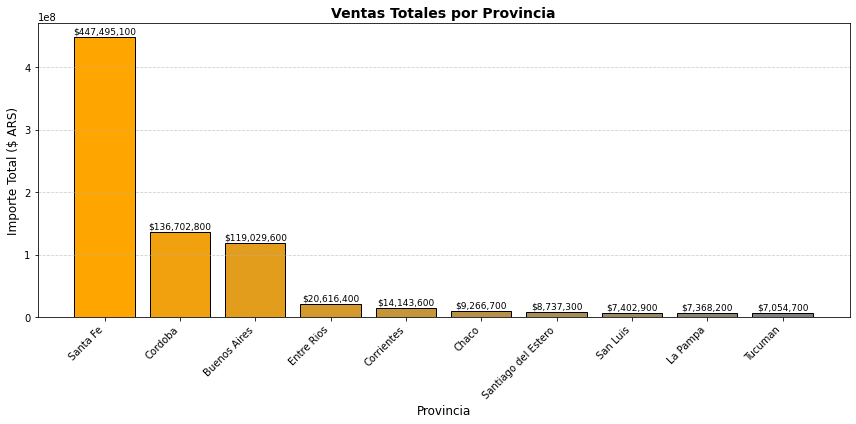

In [146]:
# Datos
df = provincias_con_mas_ingresos

# Crear escala de colores de naranja a gris
n = len(df)
custom_cmap = LinearSegmentedColormap.from_list("naranja_a_gris", ['orange', 'grey'], N=n)
colors = [custom_cmap(i / (n - 1)) for i in range(n)]

# Crear gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(df['provincia'], df['importe_total'], color=colors, edgecolor='black')

# Títulos y etiquetas
plt.title('Ventas Totales por Provincia', fontsize=14, fontweight='bold')
plt.xlabel('Provincia', fontsize=12)
plt.ylabel('Importe Total ($ ARS)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Etiquetas de valor sobre cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 2e6,
        f"${height:,.0f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()

Las provincias que generaron más ingresos totales fueron Santa Fe, Córdoba y Buenos Aires.

- Santa Fe lidera ampliamente con $447.495.100 siendo el 57,53% del total nacional.

- Le sigue Córdoba con $136.702.800 (17,58%)

- Luego Buenos Aires con $119.029.600 (15,3%).

- Estas tres provincias concentran en conjunto aproximadamente el 90% del total de ingresos.

- El resto de las provincias contribuyen con porcentajes menores, siendo Entre Ríos (2,65%) la más destacada entre ellas.


## **¿Qué clientes compraron más veces, qué productos y colores suelen elegir?** *
*Se tuvieron en cuenta los productos con más de 2 compras.

In [147]:
mayores_compras_por_cliente_producto_color = """WITH gasto_por_cliente AS (
  SELECT 
    f.cliente_id,
    c.nombre AS nombre_cliente,
    SUM(f.monto_total) AS gasto_total,
    RANK() OVER (ORDER BY SUM(f.monto_total) DESC) AS ranking_cliente
  FROM facturas f
  JOIN clientes c ON f.cliente_id = c.cliente_id
  GROUP BY f.cliente_id, c.nombre
),
detalle_productos_por_cliente AS (
  SELECT
    f.cliente_id,
    vf.producto_id,
    SUM(vf.cantidad) AS total_unidades
  FROM ventas_por_factura vf
  JOIN facturas f ON vf.factura_id = f.factura_id
  GROUP BY f.cliente_id, vf.producto_id
)

SELECT 
	gpc.ranking_cliente,
	gpc.nombre_cliente,
	p.nombre AS nombre_producto,
	categoria,
	color,
	dpc.total_unidades
FROM detalle_productos_por_cliente dpc
JOIN gasto_por_cliente gpc ON dpc.cliente_id = gpc.cliente_id
JOIN productos p ON dpc.producto_id = p.producto_id
WHERE gpc.ranking_cliente <= 10
  AND dpc.total_unidades > 2
ORDER BY gpc.ranking_cliente, dpc.total_unidades DESC;"""

mayores_compras_por_cliente_producto_color = duckdb.query(mayores_compras_por_cliente_producto_color).to_df()
mayores_compras_por_cliente_producto_color

,ranking_cliente,nombre_cliente,nombre_producto,categoria,color,total_unidades
0,1,Horacio Fabbri,Camisa denim celeste,Ropa,Celeste,4.0
1,1,Horacio Fabbri,Cartera cruzada blanco,Carteras,Blanco,4.0
2,1,Horacio Fabbri,Campera impermeable mostaza,Ropa,Mostaza,4.0
3,1,Horacio Fabbri,Porta pasaporte gris,Accesorios,Gris,3.0
4,1,Horacio Fabbri,Riñonera urbana blanco,Accesorios,Blanco,3.0
5,1,Horacio Fabbri,Camisa denim azul,Ropa,Azul,3.0
6,2,Gisela Zarate,Camisa lino gris,Ropa,Gris,3.0
7,2,Gisela Zarate,Chaleco liviano beige,Ropa,Beige,3.0
8,2,Gisela Zarate,Cartuchera cuero azul,Accesorios,Azul,3.0
9,3,Isidora Kozak,Riñonera cuero celeste,Accesorios,Celeste,3.0


Los clientes que realizaron más compras muestran patrones claros en cuanto a los productos y colores que eligen. **Horacio Fabbri**, el cliente con mayor cantidad de compras, se inclina por productos de **ropa** y **carteras**, con una clara preferencia por colores como **celeste**, **blanco** y **mostaza**. Entre sus elecciones más frecuentes se destacan **camisas de denim**, **camperas impermeables** y **carteras cruzadas**.

**Gisela Zarate** combina prendas livianas y accesorios de cuero, con una paleta dominada por tonos **gris**, **azul** y **bordó**. **Isidora Kozak** prefiere **ropa** en colores **neutros** u **oscuros**, como **negro**, **blanco** y **azul**, con un foco en **camperas bomber** y **camisas escocesas**.

**Pilar Amato** muestra una mayor variedad cromática, eligiendo productos en **bordó**, **celeste** y **nude**, con énfasis en **camisas**, **camperas** y **billeteras**. **Celeste Rivas** repite compras en tonos **celeste**, **marrón** y **gris**, particularmente en **camperas** y **pantalones**.

Otros clientes como **Luciana Ortega**, **Carla Ricci** y **Yamila Torres** también evidencian preferencias consistentes por ciertos tipos de productos (principalmente **camisas**, **cartucheras**, **bandoleras** y **chalecos**), así como por colores como **verde**, **naranja**, **violeta** y **camel**.

En general, los productos más elegidos por estos clientes son **camisas**, **camperas** y **carteras**, y los colores más frecuentes entre sus compras son **celeste**, **blanco**, **marrón**, **bordó** y **gris**. Estas tendencias permiten identificar patrones valiosos para diseñar estrategias comerciales personalizadas y optimizar el catálogo de productos más demandados por los compradores más activos.

## ¿Cuáles son los clientes con un numero mayor de compras?

In [148]:
clientes_mas_compras = """SELECT
	c.nombre,
	COUNT(f.factura_id) AS cant_compras,
	SUM(f.monto_total) AS monto_total
FROM facturas f
JOIN clientes c ON f.cliente_id = c.cliente_id
GROUP BY c.nombre
ORDER BY cant_compras DESC
LIMIT 15;"""

clientes_mas_compras = duckdb.query(clientes_mas_compras).to_df()
clientes_mas_compras

,nombre,cant_compras,monto_total
0,Karen Waisman,10,619800.0
1,Bruno Alvarez,10,962700.0
2,Ximena Juárez,10,789700.0
3,Horacio Fabbri,10,1092600.0
4,Gisela Zarate,9,851800.0
5,Eva Zarate,9,758800.0
6,Santiago Amato,8,649700.0
7,Sabrina Navarro,8,496100.0
8,Nicolás Giménez,8,706500.0
9,Yésica Salerno,8,701500.0


Los clientes con mayor número de compras son aquellos que realizaron entre **8** y **10** compras durante el período analizado. Los cuatro más destacados son: **Bruno Alvarez**, **Horacio Fabbri**, **Ximena Juárez** y **Karen Waisman**. Realizaron **10** compras cada uno, consolidándose como los clientes más recurrentes.

Entre ellos, **Horacio Fabbri** fue quien más gastó, superando el millón de pesos en compras. Le siguen **Gisela Zarate** y **Eva Zarate**, con **9** compras cada una y una factura promedio acumulado cercano a los **$800.000**.

El grupo lo completan otros clientes con **8** compras, como **Carla Ricci**, **Ulises Cervantes** y **Yésica Salerno**, todos con montos superiores a los **$700.000.** Esto sugiere que, además de la frecuencia, también presentan un gasto medio elevado.

## Clientes recurrentes vs. ocasionales

In [149]:
clientes_recurrentes_vs_ocasionales = """WITH clientes_recurrentes_ocasionales AS (
	SELECT 
	  CASE 
	    WHEN COUNT(DISTINCT factura_id) > 1 THEN 'recurrentes'
	    ELSE 'ocasionales'
	  END AS tipo_cliente
	FROM facturas
	GROUP BY cliente_id 
)

SELECT
	tipo_cliente,
	COUNT(tipo_cliente) AS tipo_de_cliente,
	CONCAT(ROUND((COUNT(tipo_cliente)/(SELECT COUNT(DISTINCT cliente_id) FROM facturas))*100,2), '%') AS total_clientes
FROM clientes_recurrentes_ocasionales
GROUP BY tipo_cliente;"""

clientes_recurrentes_vs_ocasionales = duckdb.query(clientes_recurrentes_vs_ocasionales).to_df()
clientes_recurrentes_vs_ocasionales

,tipo_cliente,tipo_de_cliente,total_clientes
0,recurrentes,2559,78.81%
1,ocasionales,688,21.19%


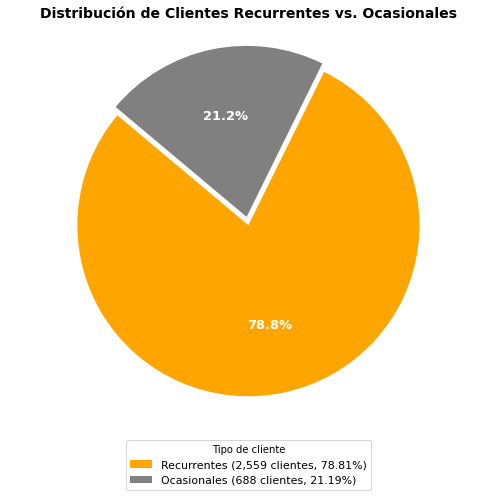

In [150]:
# Corregir nombres de columnas y tipos
df = clientes_recurrentes_vs_ocasionales
df.columns = ['tipo_cliente', 'cantidad', 'porcentaje']

# Asegurar tipos correctos
df['tipo_cliente'] = df['tipo_cliente'].astype(str)
df['cantidad'] = df['cantidad'].astype(int)
df['porcentaje'] = df['porcentaje'].astype(str)

# Preparar datos
labels = df['tipo_cliente'].str.capitalize()
sizes = df['cantidad']
colors = ['orange', 'grey']
explode = (0.05, 0)

# Crear gráfico
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=None,
    colors=colors,
    explode=explode,
    autopct='%1.1f%%',
    startangle=140,
    textprops=dict(color="white", fontsize=12)
)

# Leyenda con texto enriquecido
leyenda = [
    f"{row['tipo_cliente'].capitalize()} ({row['cantidad']:,} clientes, {row['porcentaje']})"
    for _, row in df.iterrows()
]

ax.legend(
    wedges,
    leyenda,
    title="Tipo de cliente",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=1,
    fontsize=11
)

# Estilo
plt.setp(autotexts, size=13, weight="bold")
ax.set_title('Distribución de Clientes Recurrentes vs. Ocasionales', fontsize=14, fontweight='bold')
ax.axis('equal')

plt.tight_layout()
plt.show()

Del total de clientes analizados, **2.559** (**78,81%**) fueron recurrentes, es decir, realizaron más de una compra durante el período. Solo **688** clientes (**21,19%**) compraron una única vez y se clasifican como ocasionales.

Este alto porcentaje de recurrencia indica una buena fidelización: la mayoría de los clientes no solo hacen una compra, sino que vuelven. Esto sugiere que la propuesta de valor (producto, precio, experiencia) que está funcionando para sostener la relación con el cliente más allá del primer contacto.

## ¿Cuál es la tasa de deserción y su cantidad?

In [151]:
tasa_disercion_cantidad = """WITH ultima_compra AS (
  SELECT 
    cliente_id,
    MAX(fecha) AS ultima_fecha
  FROM facturas
  GROUP BY cliente_id
),
estado_clientes AS (
  SELECT 
    cliente_id,
    ultima_fecha,
    CASE 
      WHEN ultima_fecha <= '2024-06-30' THEN 'Desertores'
      ELSE 'Activo'
    END AS estado
  FROM ultima_compra
)

SELECT 
  estado,
  COUNT(*) AS cantidad_clientes,
  CONCAT(ROUND((COUNT(*) / (SELECT COUNT(*) FROM estado_clientes))*100, 2), '%') AS porcentaje
FROM estado_clientes
GROUP BY estado;"""

tasa_disercion_cantidad = duckdb.query(tasa_disercion_cantidad).to_df()
tasa_disercion_cantidad

,estado,cantidad_clientes,porcentaje
0,Activo,1163,35.82%
1,Desertores,2084,64.18%


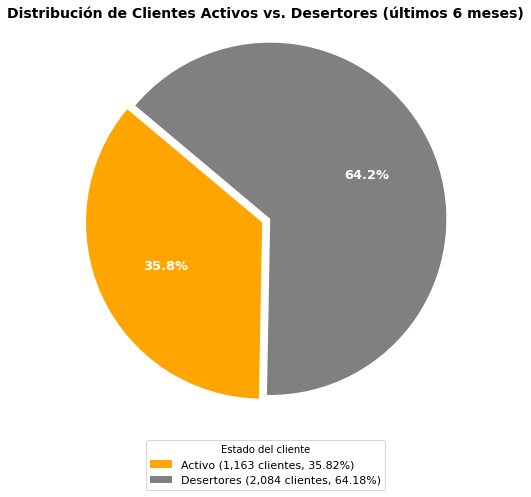

In [152]:
# Datos
df = tasa_disercion_cantidad

# Asegurar tipos correctos
df['estado'] = df['estado'].astype(str)
df['cantidad_clientes'] = df['cantidad_clientes'].astype(int)
df['porcentaje'] = df['porcentaje'].astype(str)

# Orden para que "Activo" vaya primero
df = df.set_index('estado').loc[['Activo', 'Desertores']].reset_index()

# Datos para el gráfico
labels = df['estado']
sizes = df['cantidad_clientes']
colors = ['orange', 'grey']  # naranja = activo, gris = desertores
explode = (0, 0.05)  # Resaltar desertores

# Crear gráfico de torta
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=None,
    colors=colors,
    explode=explode,
    autopct='%1.1f%%',
    startangle=140,
    textprops=dict(color="white", fontsize=12)
)

# Leyenda con cantidad y porcentaje
leyenda = [
    f"{estado} ({cantidad:,} clientes, {porcentaje})"
    for estado, cantidad, porcentaje in zip(labels, sizes, df['porcentaje'])
]

ax.legend(
    wedges,
    leyenda,
    title="Estado del cliente",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=1,
    fontsize=11
)

# Estilo general
plt.setp(autotexts, size=13, weight="bold")
ax.set_title('Distribución de Clientes Activos vs. Desertores (últimos 6 meses)', fontsize=14, fontweight='bold')
ax.axis('equal')

plt.tight_layout()
plt.show()


Al evaluar el comportamiento de los clientes según su última fecha de compra, se observa que el **64,18%** del total (**2.084** clientes) no ha realizado ninguna compra en los últimos seis meses. Esto los clasifica como clientes desertores.

Por otro lado, solo el **35,82%** (**1.163** clientes) se considera activo, al haber comprado dentro del semestre más reciente del período analizado.